# Clústers de fallecidos por covid en Argentina

## Con variables acumuladas

El objetivo del trabajo es buscar agrupamientos entre departamentos de la Argentina que hayan tenido algún comportamiento similar en la cantidad de fallecidos por Covid19 durante los meses de pandemia. La idea también es tener en cuenta la relación espacial que existe entre los departamentos por eso se tiene en cuenta la restricción espacial basada en la cercanía para formar los clústers.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sklearn as sk
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [36]:
covid = gpd.read_file('datos/covid_periodos.shp', index = True)
covid = covid.set_index(['link','mes']).sort_index(level = 0)
covid = covid.loc[pd.IndexSlice[:,'2020-03':],:]
covid = covid.to_crs('POSGAR94')

# Separamos los campos geometricos del dataframe
geo = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry']
geo = geo.reset_index(level = 'mes', drop = True)
centroides = covid.loc[pd.IndexSlice[:,'2021-01'],'geometry'].to_crs('POSGAR94').centroid
centroides = centroides.reset_index(level = 'mes', drop = True)
print("las cordenadas CRS son: "+str(geo.crs))
codiprov = covid.loc[pd.IndexSlice[:,'2021-01'],['codpcia','departamen','provincia']]


columnas = ['clasificac', 'fallecido']

# Variables acumuladas a partir del mes que todas tienen al menos 1 

covid_acum = covid[columnas].groupby(covid.index.get_level_values(0)).cumsum()
# buscamos el mes en que todos los dptos tienen al menos 1 contagio
mes = 0
valor = True
while valor == True:
    Mes = covid.index.get_level_values(1).unique()[mes]
    valor = np.any(covid_acum.loc[pd.IndexSlice[:,Mes],'clasificac'] == 0)
    mes +=1
print("El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: "+str(Mes))
covid_acum['personas'] = covid.personas

covid2 = covid_acum.loc[pd.IndexSlice[:,Mes:],:]
covid_ult_mes = covid_acum.loc[pd.IndexSlice[:,'2021-07'],:]
covid_ult_mes = covid_ult_mes.reset_index(level = 'mes', drop = True)

#casos cada 10 mil habitantes
fallecidos = covid_acum.fallecido#/(covid.personas/10000)
positivos = covid_acum.clasificac/(covid.personas/10000)

# Calculamos el coeficiente de localización
from lq import *
lq_ = lq(covid2,'fallecido','clasificac')
lq_fall_conf = lq_[2]
ind_fall_conf = lq_[0]

variable = fallecidos

las cordenadas CRS son: POSGAR94
El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


C:\Users\paban\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':


A partir de enero del 2021 es cuando todos los departamentos de Argentina, en total 525, tuvieron al menos un contagiado de covid - 19. La idea es trabajar con la variable acumulada de contagiados y fallecidos mes a mes. Para no trabajar con las variables en sus valores discretos se transforma esos datos en el coeficiente de localización de las personas fallecidas sobre la cantidad de contagios. 

$\frac{{f_i}/{c_i}/{F}/{C}}$

In [37]:
from libpysal.weights import Queen, Rook, KNN
covid_acum_geo = covid_ult_mes.copy()
covid_acum_geo['geometry'] = geo
#w_queen = Queen.from_dataframe(covid_acum_geo)
#w_rook = Rook.from_dataframe(covid_acum_geo)
w_knn = KNN.from_dataframe(covid_acum_geo, k = 6)
#covid_acum_geo

In [38]:
import sklearn.pipeline
import sklearn.preprocessing
from elegir_modelo import metodo
import procesos

pipe_coord = sk.pipeline.Pipeline([
    ('periodos', procesos.peri_columna()),
    ('coordenadas', procesos.agrega_centroides(centroides))
])

norm_l1 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler())])#,
    #('norm_l1', sk.preprocessing.Normalizer('l1'))])
norm_l2 = sk.pipeline.Pipeline([
     ('std_scale', sk.preprocessing.StandardScaler()),
    ('norm_l2', sk.preprocessing.Normalizer('l2'))])

pipe = sk.pipeline.Pipeline([
    ('coord', pipe_coord),
    ('norml1', norm_l1)])


In [39]:
# ddefinimos unas metricas para evaluar resultaods
from lq import *
#lqcovid = lq_peri(covid_acum[['clasificac','personas']])
lqcovid = lq_peri(covid2[['fallecido','personas']])

from sklearn.metrics import silhouette_score,  calinski_harabasz_score
def siluetas(X, model):
    return silhouette_score(X, model.labels_)
def calinski(x, model):
    return sk.metrics.calinski_harabasz_score(x, model.labels_)
def inv_davies_bouldin(X,model):
    return (sk.metrics.davies_bouldin_score(X,model.labels_))**-1
def indice_lq(X, model):
    grupos = model.labels_
    ind = lqcovid.calcular_indice_debil(grupos)
    return 1-ind

In [40]:
import sklearn.cluster 
hiperparam = {
    'n_clusters': np.arange(5,20), 'init': ['k-means++', 'random'],
    'n_init' : [10]
}

metricas = {'sil': siluetas, 'cal': calinski, 'dav': inv_davies_bouldin, 'lqg': indice_lq}

#X = pipe.fit_transform(fallecidos)
#X = pipe.fit_transform(positivos)
X = pipe.fit_transform(variable)
kmeans = metodo(sk.cluster.KMeans(), hiperparam, metricas)
kmeans.fit(X)

hyperparam_aglo = {'n_clusters': np.arange(5,20),
 'affinity': ['l1', 'l2', 'manhattan', 'cosine'],
 'linkage': ['complete', 'average', 'single']}

aglo = metodo(sk.cluster.AgglomerativeClustering(),hyperparam_aglo, metricas)
aglo.fit(X)


In [49]:
pipe2 = sk.pipeline.Pipeline([
    ('periodos', procesos.peri_columna()),
    ('norm', norm_l1)])

#XX = pipe2.fit_transform(positivos)
XX = pipe2.fit_transform(variable)
hyperparam_aglo2= {'n_clusters': np.arange(2,20),
    'connectivity': [w_knn.sparse],
 'affinity': ['l1', 'l2', 'manhattan', 'cosine'],
 'linkage': ['complete', 'average', 'single']}

aglo_geo = metodo(sk.cluster.AgglomerativeClustering(),hyperparam_aglo2, metricas)
aglo_geo.fit(XX)

In [50]:
from sklearn.decomposition import PCA
import copy 

pipe_pca = sk.pipeline.Pipeline([
     ('periodos', procesos.peri_columna()),
     ('norma', norm_l2),
     ('pca', PCA(n_components = 2))])

#X_pca = pipe_pca.fit_transform(positivos)
X_pca = pipe_pca.fit_transform(variable)
aglo_geo2 = copy.copy(aglo_geo)
aglo_geo2.fit(X_pca)


In [51]:
#cent = procesos.agrega_centroides(covid.geometry.centroid)
#cc = norm_l2.fit_transform(cent.fit_transform(covid)[:,-2:])
#cc2 = cc.reshape(525,17,2)
#XX2 = XX.reshape(525,17,1)
#XX2 = np.c_[XX2, cc2]

import tslearn.clustering as ts
hiperparam_tskm = {
    'n_clusters': [5,8,10,12], 'init': ['k-means++', 'random'],
    'n_init' : [1]
}

def siluetas2(X, model):
    X = X[:,:,0]
    return silhouette_score(X, model.labels_)
def calinski2(X, model):
    X = X[:,:,0]
    return sk.metrics.calinski_harabasz_score(X, model.labels_)
def inv_davies_bouldin2(X,model):
    X = X[:,:,0]
    return (sk.metrics.davies_bouldin_score(X,model.labels_))**-1


met = {'sil': siluetas2, 'cal': calinski2, 'dav': inv_davies_bouldin2, 'lqg': indice_lq}

tskm = metodo(ts.TimeSeriesKMeans(),hiperparam_tskm, metricas)
tskm.fit(XX)


In [44]:
hiperparam_kshape = {
    'n_clusters': (5,8,10,12)
}

kshape = metodo(ts.KShape(),hiperparam_kshape, metricas)
kshape.fit(XX)

In [45]:
def mapa_grupos(model):
    covid_acum_geo['grup'] = model.best_model_['modelo'].iloc[0].labels_
    gpd.GeoDataFrame(covid_acum_geo).plot('grup', figsize = (10,8))

def metric_grup(model):
    std = sk.preprocessing.StandardScaler()
    for i in model.metrics.columns:
        met = model.metrics[i]
        met = std.fit_transform(met.values.reshape(-1,1))
        plt.scatter(model.modelos['modelo'].apply(lambda x: x.n_clusters) , met, label = i)
    plt.legend()
    plt.show()

In [52]:
lista = [kmeans,aglo, aglo_geo,aglo_geo2, tskm,kshape]
l = []
for i in lista:
    df = i.best_metrics_.copy()
    model = i.best_model_
    df['grupos'] = model['modelo'].iloc[0].n_clusters
    df['modelo'] = model['modelo'].iloc[0]
    l.append(df)    

pd.concat(l)

,sil,cal,dav,lqg,grupos,modelo
9,0.355442,451.257542,1.195681,0.735479,14,KMeans(n_clusters=14)
33,0.767262,66.974460,9.068655,0.640306,8,"AgglomerativeClustering(affinity='l1', linkage..."
78,0.767262,66.974460,9.068655,0.640306,8,"AgglomerativeClustering(affinity='l1', linkage..."
123,0.767262,66.974460,9.068655,0.640306,8,"AgglomerativeClustering(affinity='l1', linkage..."
0,0.936598,165.477967,23.052007,0.500000,2,"AgglomerativeClustering(affinity='l1',\n ..."
18,0.936598,165.477967,23.052007,0.500000,2,"AgglomerativeClustering(affinity='l1',\n ..."
36,0.936598,165.477967,23.052007,0.500000,2,"AgglomerativeClustering(affinity='l1',\n ..."
54,0.936598,165.477967,23.052007,0.500000,2,"AgglomerativeClustering(affinity='l1',\n ..."
72,0.936598,165.477967,23.052007,0.500000,2,"AgglomerativeClustering(affinity='l1',\n ..."
90,0.936598,165.477967,23.052007,0.500000,2,"AgglomerativeClustering(affinity='l1',\n ..."


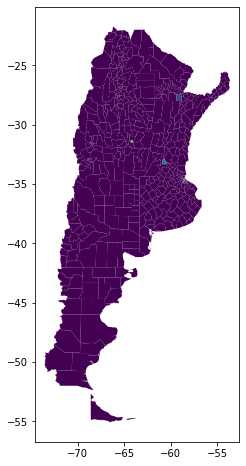

In [48]:
mapa_grupos(aglo_geo)

## Guardar los objetos como resultados

In [14]:
import pickle 
lista2 = ['kmeans','aglo', 'aglo_geo','aglo_geo2', 'tskm','kshape']
for l in range(len(lista)):
    with open("Resultados/{}fallpos.pickle".format(lista2[l]), "wb") as f:
        pickle.dump(lista[l],f)


# Armado de Bases para Geoda

In [15]:
def guardar_shp(bd, nombre):
    gdf = gpd.GeoDataFrame(pipe2.fit_transform(bd))
    meses = []
    for i in list(gdf.columns):
        m = 'mes'+str(i)
        meses.append(m)
    gdf.columns = meses
    gdf = gdf.set_index(codiprov.index.get_level_values(0))
    gdf['personas'] = covid_ult_mes.personas
    gdf['geometry'] = geo
    gdf.to_file('Geodabd/'+nombre+'.shp')
    print('guardado '+nombre+' comun')
    gdf = gpd.GeoDataFrame(pipe_pca.fit_transform(bd))
    meses = []
    for i in list(gdf.columns):
        m = 'mes'+str(i)
        meses.append(m)
    gdf.columns = meses
    gdf = gdf.set_index(codiprov.index.get_level_values(0))
    gdf['personas'] = covid_ult_mes.personas
    gdf['geometry'] = geo
    gdf.to_file('Geodabd/'+nombre+'_pca.shp')
    print('guardado '+nombre+' pca')
    
    

In [16]:
bds = {'fallec': fallecidos, 'positiv': positivos, 'fall_pos': ind_fall_conf}
for k in bds.keys():
    guardar_shp(bds[k], k)

guardado fallec comun
guardado fallec pca
guardado positiv comun
guardado positiv pca
guardado fall_pos comun
guardado fall_pos pca
